In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import pickle

from tqdm import tqdm

from collections import Counter

from linearization.analyzer import SAELinearizer
from linearization.visualization import visualize_topk

In [3]:
EXPANSION_FACTOR = 32

In [7]:
# OVERRIDE = True
OVERRIDE = False

path = f"../data/pickled_linearizers/gelu_1l_{EXPANSION_FACTOR}.pkl"

# Automated SAE name generation
seeds = [42, 43]
# layers = [0, 1]
names1 = ["ln2_normalized", "mlp_out", "transcoder"]
names2 = ["ln2.hook_normalized", "hook_mlp_out", "ln2.hook_normalized"]

sae_names = []
for seed in seeds:
    # for layer in layers:
    for name1, name2 in zip(names1, names2):
        sae_names.append(
            f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_1l/seed{seed}_{name1}/final_sparse_autoencoder_gelu-1l_blocks.0.{name2}_{512 * EXPANSION_FACTOR}.pt"
        )

if os.path.exists(path) and not OVERRIDE:
    lin = pickle.load(open(path, "rb"))
else:
    lin = SAELinearizer(
        model_name="gelu-1l",
        sae_names=sae_names,
        layers=[0, 0, 0, 0, 0, 0],
        dataset_name="NeelNanda/pile-10k",
        act_name="normalized",
        num_batches=10,
        half_precision=False,
        # transcoder=True,
        # use_gpt=True,
        # dict_mult=64,
        # hook_point="resid_mid",
        run_analysis=True,
    )
    with open(path, "wb") as f:
        pickle.dump(lin, f)

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Model device: cuda:0
Tokens shape: torch.Size([125337, 128]), dtype: torch.int64, device: cuda:0
Loading ../scripts/checkpoints/32x_gelu_1l/seed42_ln2_normalized/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt from disk
Encoder device: cuda:0
Loading ../scripts/checkpoints/32x_gelu_1l/seed42_mlp_out/final_sparse_autoencoder_gelu-1l_blocks.0.hook_mlp_out_16384.pt from disk
Encoder device: cuda:0
Loading ../scripts/checkpoints/32x_gelu_1l/seed42_transcoder/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt from disk
Encoder device: cuda:0
Loading ../scripts/checkpoints/32x_gelu_1l/seed43_ln2_normalized/final_sparse_autoencoder_gelu-1l_blocks.0.ln2.hook_normalized_16384.pt from disk
Encoder device: cuda:0
Loading ../scripts/checkpoints/32x_gelu_1l/seed43_mlp_out/final_sparse_autoencoder_gelu-1l_blocks.0.hook_mlp_out_16384.pt from disk
Encoder device: cuda:0
Loadi

100%|██████████| 10/10 [00:00<00:00, 29.92it/s]


Num dead 0.0


100%|██████████| 10/10 [00:00<00:00, 26.02it/s]


Num dead 0.036865234375


100%|██████████| 10/10 [00:00<00:00, 27.70it/s]


Num dead 0.0118408203125


100%|██████████| 10/10 [00:00<00:00, 30.58it/s]


Num dead 0.0


100%|██████████| 10/10 [00:00<00:00, 27.29it/s]


Num dead 0.03436279296875


100%|██████████| 10/10 [00:00<00:00, 26.65it/s]


Num dead 0.00811767578125


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


In [11]:
# 5 features, uniformly sampled by frequency, seed 42 layer 0:

# sae_name = "../scripts/checkpoints/32x_gelu_2l/layer0/seed42_transcoder/final_sparse_autoencoder_gelu-2l_blocks.0.ln2.hook_normalized_16384.pt"
LAYER = 0
SEED = 42
sae_name = f"../scripts/checkpoints/{EXPANSION_FACTOR}x_gelu_1l/seed{SEED}_transcoder/final_sparse_autoencoder_gelu-1l_blocks.{LAYER}.ln2.hook_normalized_{512 * EXPANSION_FACTOR}.pt"
freqs = lin.frequencies[sae_name]

my_sample = np.argsort(freqs.cpu().numpy())[::-1][:: len(freqs) // 5]
print(" ".join([f"{x}: {freqs[x].item()}" for x in my_sample]))

11712: 0.2850708067417145 5150: 0.02271728590130806 4482: 0.004931640811264515 14892: 0.0018066406482830644 855: 0.0007812500116415322 13771: 0.0


In [12]:
def set_and_visualize(feature_idx, l=0):
    lin.set_feature(feature_idx, sae_name, num_batches=10)

    fig, axs = plt.subplots(2, 1, figsize=(20, 10))

    ax = visualize_topk(
        examples=lin.top_examples["examples"].detach().cpu().numpy(),
        activations=lin.top_examples["activations"].detach().cpu().numpy(),
        columns=lin.top_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[0],
    )
    axs[0].set_title(f"Feature {lin.feature_idx} for Transcoder l{l}, top")

    ax = visualize_topk(
        examples=lin.uniform_ranked_examples["examples"].detach().cpu().numpy(),
        activations=lin.uniform_ranked_examples["activations"].detach().cpu().numpy(),
        columns=lin.uniform_ranked_examples["cols"].detach().cpu().numpy(),
        model=lin.model,
        trim=20,
        zero_negatives=False,
        ax=axs[1],
    )
    axs[1].set_title(f"Feature {lin.feature_idx} for Transcoder l{l}, uniform")

    plt.tight_layout()
    plt.show()

In [14]:
set_and_visualize(my_sample[0], l=0)

  0%|          | 0/10 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.47 GiB. GPU 0 has a total capacty of 23.65 GiB of which 1.11 GiB is free. Process 1076465 has 10.54 GiB memory in use. Process 1103763 has 11.99 GiB memory in use. Of the allocated memory 8.41 GiB is allocated by PyTorch, and 1.69 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

100%|██████████| 10/10 [00:00<00:00, 26.61it/s]
/tmp/ipykernel_668757/1707984514.py:28: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/home/phil/miniconda3/envs/mats/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


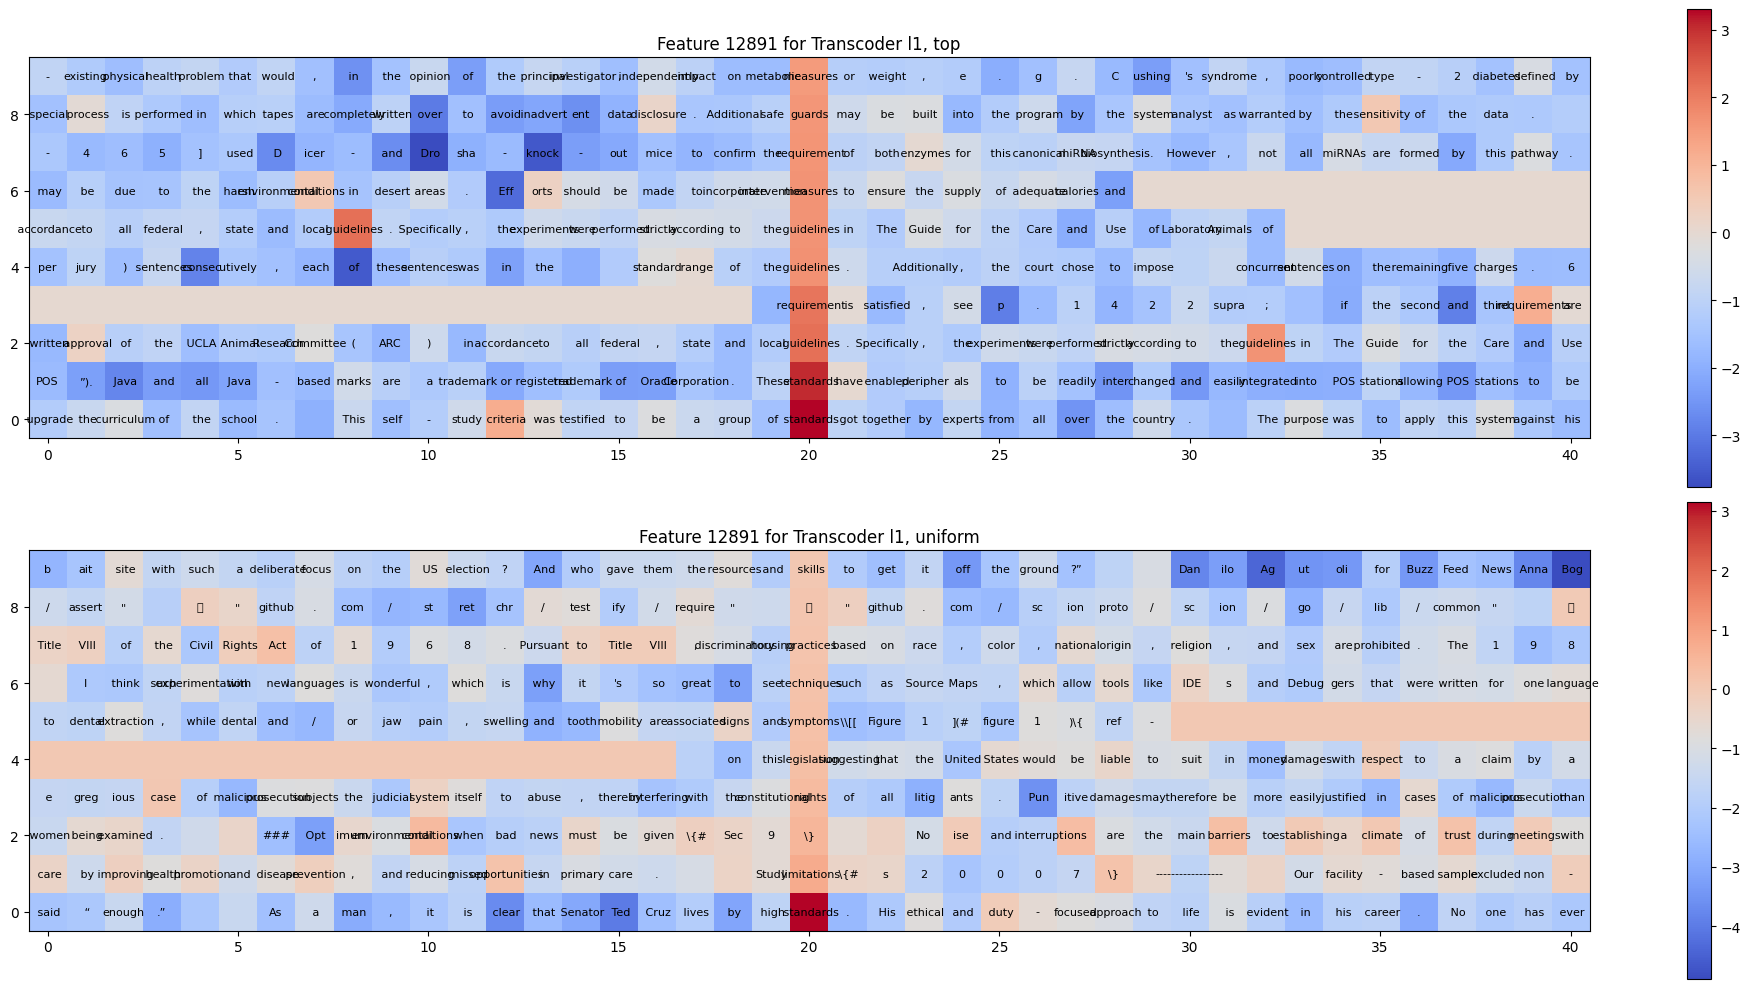

In [ ]:
set_and_visualize(my_sample[2], l=1)